<a href="https://colab.research.google.com/github/soutrik71/School_of_AI_ERA/blob/main/session7/ERA1S7F10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using the best model with Image Augmentation we add LR scheduler

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 454160963.52it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 15126834.89it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 216493704.70it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5772887.51it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# The model
Let's start with the model we first saw

In [5]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        )


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
              ReLU-6           [-1, 32, 24, 24]               0
       BatchNorm2d-7           [-1, 32, 24, 24]              64
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             320
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1) # addding of LR scheduler we can tryout other lRs as well as ReduceLRonPLateau


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.13794854283332825 Batch_id=468 Accuracy=86.65: 100%|██████████| 469/469 [00:25<00:00, 18.18it/s]



Test set: Average loss: 0.0607, Accuracy: 9824/10000 (98.24%)

EPOCH: 1


Loss=0.05200251564383507 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:23<00:00, 20.32it/s]



Test set: Average loss: 0.0405, Accuracy: 9869/10000 (98.69%)

EPOCH: 2


Loss=0.04140068218111992 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:20<00:00, 22.47it/s]



Test set: Average loss: 0.0336, Accuracy: 9903/10000 (99.03%)

EPOCH: 3


Loss=0.07808329910039902 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:21<00:00, 22.26it/s]



Test set: Average loss: 0.0308, Accuracy: 9890/10000 (98.90%)

EPOCH: 4


Loss=0.0418878048658371 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:21<00:00, 21.40it/s]



Test set: Average loss: 0.0332, Accuracy: 9882/10000 (98.82%)

EPOCH: 5


Loss=0.07754498720169067 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:22<00:00, 21.03it/s]



Test set: Average loss: 0.0242, Accuracy: 9922/10000 (99.22%)

EPOCH: 6


Loss=0.061365317553281784 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:23<00:00, 20.32it/s]



Test set: Average loss: 0.0207, Accuracy: 9937/10000 (99.37%)

EPOCH: 7


Loss=0.011696522124111652 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:22<00:00, 20.86it/s]



Test set: Average loss: 0.0214, Accuracy: 9937/10000 (99.37%)

EPOCH: 8


Loss=0.027557894587516785 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:22<00:00, 21.10it/s]



Test set: Average loss: 0.0199, Accuracy: 9937/10000 (99.37%)

EPOCH: 9


Loss=0.057884007692337036 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:21<00:00, 21.33it/s]



Test set: Average loss: 0.0203, Accuracy: 9936/10000 (99.36%)

EPOCH: 10


Loss=0.04202042147517204 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:22<00:00, 21.29it/s]



Test set: Average loss: 0.0199, Accuracy: 9926/10000 (99.26%)

EPOCH: 11


Loss=0.026343949139118195 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:21<00:00, 21.50it/s]



Test set: Average loss: 0.0210, Accuracy: 9930/10000 (99.30%)

EPOCH: 12


Loss=0.006624260917305946 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:22<00:00, 21.19it/s]



Test set: Average loss: 0.0202, Accuracy: 9933/10000 (99.33%)

EPOCH: 13


Loss=0.016489429399371147 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:21<00:00, 22.29it/s]



Test set: Average loss: 0.0198, Accuracy: 9931/10000 (99.31%)

EPOCH: 14


Loss=0.013116572052240372 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:21<00:00, 21.77it/s]



Test set: Average loss: 0.0198, Accuracy: 9931/10000 (99.31%)

EPOCH: 15


Loss=0.04433055594563484 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:21<00:00, 21.92it/s]



Test set: Average loss: 0.0194, Accuracy: 9935/10000 (99.35%)

EPOCH: 16


Loss=0.023286275565624237 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:21<00:00, 21.84it/s]



Test set: Average loss: 0.0191, Accuracy: 9934/10000 (99.34%)

EPOCH: 17


Loss=0.01250071544200182 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:20<00:00, 22.56it/s]



Test set: Average loss: 0.0197, Accuracy: 9937/10000 (99.37%)

EPOCH: 18


Loss=0.038351912051439285 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:20<00:00, 23.20it/s]



Test set: Average loss: 0.0200, Accuracy: 9930/10000 (99.30%)

EPOCH: 19


Loss=0.00885955523699522 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:21<00:00, 22.01it/s]



Test set: Average loss: 0.0192, Accuracy: 9930/10000 (99.30%)



# Let's Train and test our model

This time let's add a scheduler for out LR.

Text(0.5, 1.0, 'Test Accuracy')

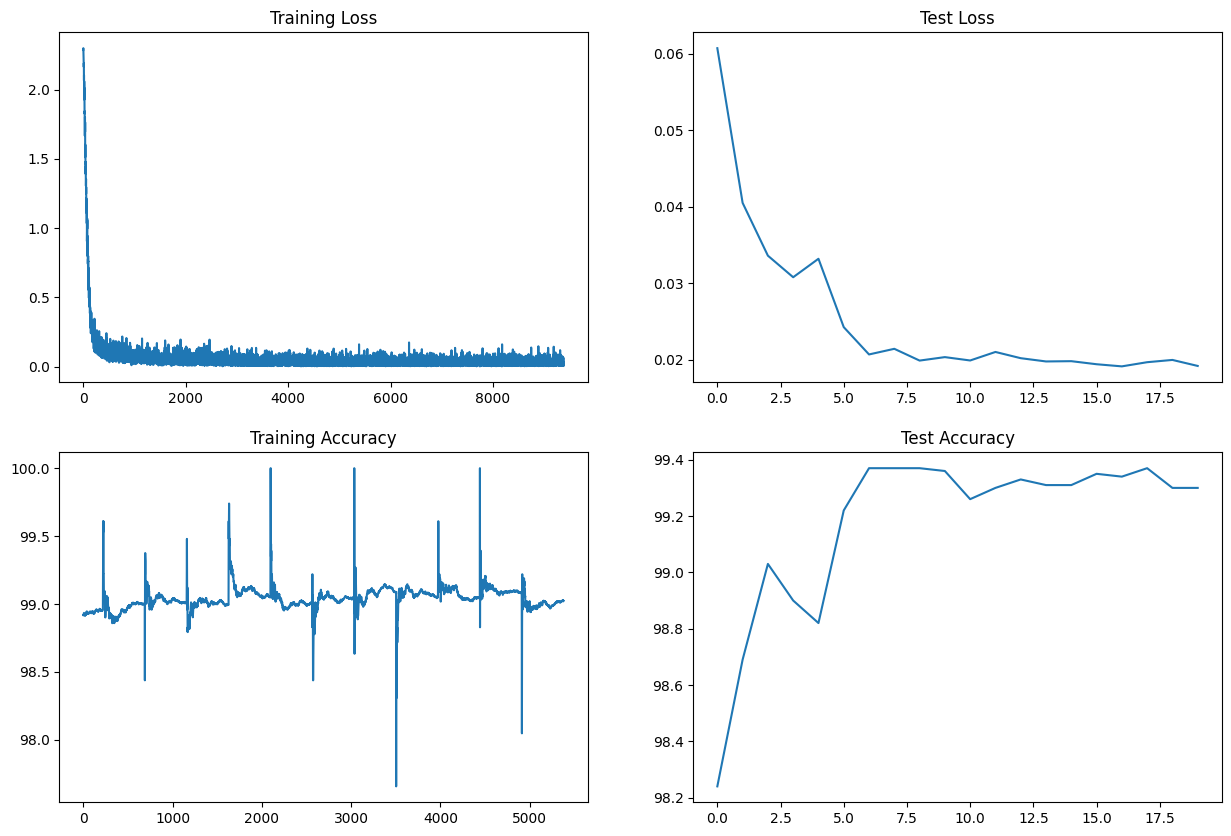

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

bt = [t_items.item() for t_items in train_losses]
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(bt)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

Target:\
Add LR Scheduler

Results:\
Parameters: 13.8k\
Best Train Accuracy: 99.21\
Best Test Accuracy: 99.45 (9th Epoch), 99.48 (20th Epoch)\

Analysis:\
Finding a good LR schedule is hard. We have tried to make it effective by reducing LR by the 10th after the 6th epoch.\
It did help in getting to 99.4 or faster, but the final accuracy is not more than 99.5. Possibly a good scheduler can do wonders here!\